<a href="https://colab.research.google.com/github/dzeko5959/AI/blob/main/ML/UDEM/A2_2_Seunghyeon_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Importing and splitting data**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving A1.4 Vino Tinto.csv to A1.4 Vino Tinto.csv


In [ ]:
import pandas as pd

df = pd.read_csv("A1.4 Vino Tinto.csv")
print(df.head())

   acidezFija  acidezVolatil  acidoCitrico  azucarResidual  cloruros  \
0         7.4           0.70          0.00             1.9     0.076   
1         7.8           0.88          0.00             2.6     0.098   
2         7.8           0.76          0.04             2.3     0.092   
3        11.2           0.28          0.56             1.9     0.075   
4         7.4           0.70          0.00             1.9     0.076   

   dioxidoAzufreLibre  dioxidoAzufreTotal  densidad    pH  sulfatos  alcohol  \
0                11.0                34.0    0.9978  3.51      0.56      9.4   
1                25.0                67.0    0.9968  3.20      0.68      9.8   
2                15.0                54.0    0.9970  3.26      0.65      9.8   
3                17.0                60.0    0.9980  3.16      0.58      9.8   
4                11.0                34.0    0.9978  3.51      0.56      9.4   

   calidad  
0        5  
1        5  
2        5  
3        6  
4        5  


If the alidad is more than 6, set to 1, otherwise set to 0, to generate binarized output variables

In [ ]:
df["calidad_binaria"] = (df["calidad"] >= 6).astype(int)
df.drop(columns=["calidad"], inplace=True)

X = df.drop(columns=["calidad_binaria"])
y = df["calidad_binaria"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**2. Find important variables for logistic regression**

Using GLM functions, we learn a logistic regression model

In [ ]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)

model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
result = model.fit()

print(result.summary())

significant_vars = result.pvalues.sort_values().index[1:3]
print("Las dos variables más importantes son:", significant_vars)

X_train_important = X_train[significant_vars]
X_test_important = X_test[significant_vars]

                 Generalized Linear Model Regression Results                  
Dep. Variable:        calidad_binaria   No. Observations:                 1279
Model:                            GLM   Df Residuals:                     1267
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -663.81
Date:                Mon, 24 Mar 2025   Deviance:                       1327.6
Time:                        14:13:32   Pearson chi2:                 1.57e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2907
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 73.5752     88

As for the model, 'acidezVolatil' and 'sulfatos' are the most important variables, 'acidezVolatil' has a negative correlation, and 'sulfatos' has a positive correlation.

**3. Create and visualize LDA models**

Train the LDA model, and visualize the classification boundary between two variables.

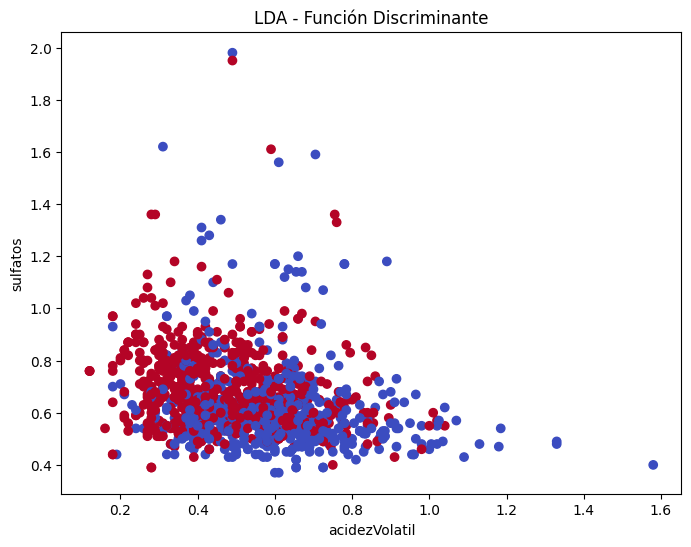

In [ ]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_important, y_train)

plt.figure(figsize=(8,6))
plt.scatter(X_train_important.iloc[:, 0], X_train_important.iloc[:, 1], c=y_train, cmap='coolwarm')
plt.title('LDA - Función Discriminante')
plt.xlabel(significant_vars[0])
plt.ylabel(significant_vars[1])
plt.show()

**4. Create and Visualize Decision Tree Models**

For learning and pruning the decision tree model, we find the optimal α value in the LOOCV scheme, and visualize the optimized tree model.

Mejor valor de alpha: 0.001


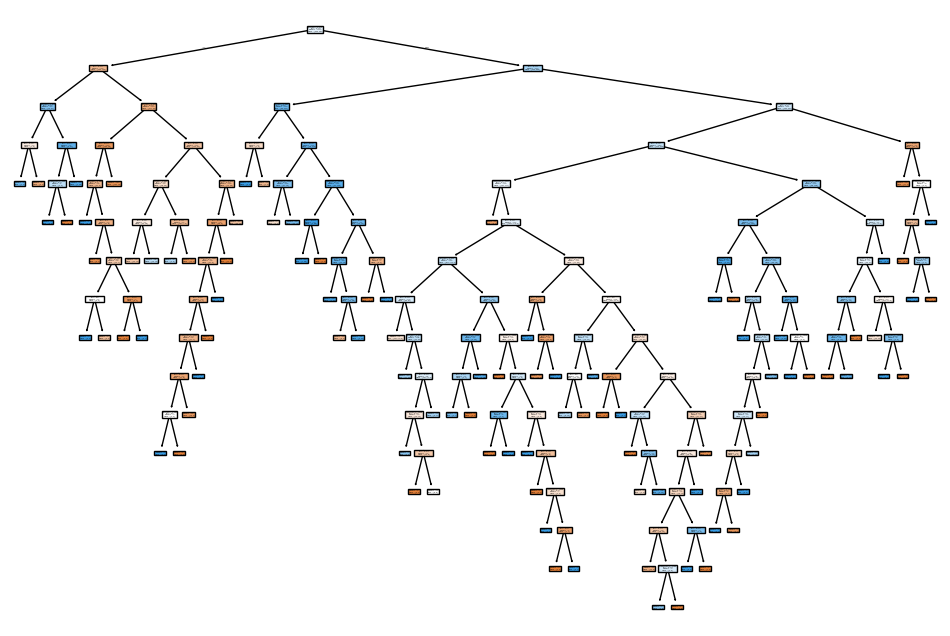

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

alphas = np.linspace(0.001, 0.1, 20)
scores = []

for alpha in alphas:
    tree = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
    score = cross_val_score(tree, X_train_important, y_train, cv=cv)
    scores.append(np.mean(score))

best_alpha = alphas[np.argmax(scores)]
print(f"Mejor valor de alpha: {best_alpha}")

tree_model = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
tree_model.fit(X_train_important, y_train)

plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=significant_vars, filled=True)
plt.show()

The pruning strength is relatively low, which causes the model to maintain a slightly more complex tree structure.

**5. Model evaluation**

The accuracy, sensitivity, specificity, and AUC of the two models are evaluated and compared.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

lda_pred = lda.predict(X_test_important)
lda_prob = lda.predict_proba(X_test_important)[:, 1]
print("LDA Report:\n", classification_report(y_test, lda_pred))
print("LDA AUC:", roc_auc_score(y_test, lda_prob))

tree_pred = tree_model.predict(X_test_important)
tree_prob = tree_model.predict_proba(X_test_important)[:, 1]
print("Decision Tree Report:\n", classification_report(y_test, tree_pred))
print("Decision Tree AUC:", roc_auc_score(y_test, tree_prob))

LDA Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       149
           1       0.68      0.66      0.67       171

    accuracy                           0.65       320
   macro avg       0.65      0.65      0.65       320
weighted avg       0.65      0.65      0.65       320

LDA AUC: 0.7074845951567958
Decision Tree Report:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67       149
           1       0.71      0.67      0.69       171

    accuracy                           0.68       320
   macro avg       0.68      0.68      0.68       320
weighted avg       0.68      0.68      0.68       320

Decision Tree AUC: 0.732662192393736


In the case of LDA, the accuracy was 65%, and the AUC recorded 0.71. Overall, the performance is good, but the precision of class 1 is higher.
On the other hand, in the case of Decision Tree, the accuracy was 68%, and the AUC recorded 0.73.
Decision Tree achieves higher accuracy than LDA and performs better for Class 1; it performs better for both recall and precision.